In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchtext
from torchtext import data
import pickle
import spacy

SEED = 1234

In [2]:
data_dir = '../data/processed/'
data_name = 'longest10.json'
prefix = data_name[:-5]
FIX_WORD_LENGTH = 101


file_embedding = prefix + '_embedding.pkl'
file_dict = prefix + '_dict.pkl'
tokenized_train_data = prefix + '_train.pkl'
tokenized_valid_data = prefix + '_valid.pkl'

In [5]:
import numpy as np
np.array([[1, 2]]).tolist()

[[1, 2]]

In [3]:
TEXT = data.Field(lower=True,include_lengths=False, tokenize = 'spacy')
LABEL = data.Field( dtype = torch.int)
dataFields = {'content': ('content', TEXT), 
              'author_label': ('author_label', LABEL)}

dataset= data.TabularDataset(path=data_dir+data_name, 
                                            format='json',
                                            fields=dataFields, 
                                            skip_header=True)

import random
SEED = 1234
train_data, valid_data = dataset.split(split_ratio=0.8,random_state = random.seed(SEED))

MAX_VOCAB_SIZE = 20_000
TEXT.build_vocab(dataset, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

### New way tokenizing and batching

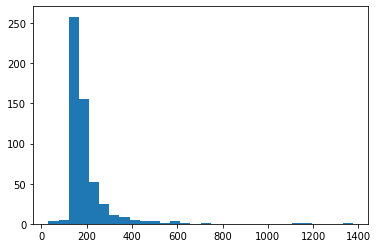

In [4]:
len_train = [len(i.content) for i in train_data.examples]
plt.hist(len_train,bins=30)
plt.show()

In [5]:

def pad_to_n(ls, n ):
    """ls list to be cut/padded to length n"""
    ls= ls[:n]
    if len(ls)<n: ls=(['<pad>']*(n-len(ls))) + ls
    return ls

In [6]:
token2index_dict = dict(TEXT.vocab.stoi)
with open(data_dir+file_dict, 'wb') as f:
    pickle.dump(token2index_dict, f)
        
#with open(data_dir+file_dict, 'rb') as f:
#    token2index_dict = pickle.load(f)


In [7]:

with open(data_dir+file_embedding, 'wb') as f:
    pickle.dump(TEXT.vocab.vectors.tolist(), f)

In [8]:
#Tokenize and save

def token2index(token_list, token2index_dict):
    return [token2index_dict[i] for i in  token_list]

def index_pad_data(data, fixed_word_length, token2index_dict):  
    data = [pad_to_n(i, fixed_word_length) for i in data]
    indexed = [token2index(t,token2index_dict ) for t in data] 
    return indexed

def tokenize_and_save(data, fixed_text_length, token2index_dir, data_dir, file_name):
  
    data_list = [i.content for i in data.examples]
    labels_list = [i.author_label for i in data.examples]
    data_list = index_pad_data(data_list, fixed_text_length, token2index_dir)
    with open(data_dir+file_name, 'wb') as f:
        pickle.dump((data_list,labels_list), f)

In [9]:

tokenize_and_save(train_data, FIX_WORD_LENGTH, token2index_dict, data_dir, tokenized_train_data)
tokenize_and_save(valid_data, FIX_WORD_LENGTH, token2index_dict, data_dir, tokenized_valid_data)